### Edgar Moises Hernandez-Gonzalez
#### 14/05/20-15/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x8
##### Validacion cruzada

In [0]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09E.csv", header=None)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [9]:
print(x.shape)
print(y.shape)

(576, 22000)
(576, 1)


In [10]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 576


In [11]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 4


In [12]:
# codificar etiquetas con valores de 0 a nClases-1
y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((576,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [14]:
#llamar a unir_espectrogramas_vertical_resize(data)
x = unir_espectrogramas_vertical_resize(x)

0
100
200
300
400
500


In [15]:
print(x.shape)

(576, 264, 8)


In [16]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

555.4778442263605
0.0007544479629820306
4.019159298145114


In [0]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [18]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99906087
1.3569207e-06
0.0072287037


In [19]:
#convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(576, 1, 264, 8, 1)


In [0]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_STFT09_CV.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
skf = StratifiedKFold(n_splits = 10)

In [0]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.29310, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_STFT09_CV.hdf5

Epoch 00002: val_accuracy did not improve from 0.29310

Epoch 00003: val_accuracy did not improve from 0.29310

Epoch 00004: val_accuracy did not improve from 0.29310

Epoch 00005: val_accuracy did not improve from 0.29310

Epoch 00006: val_accuracy did not improve from 0.29310

Epoch 00007: val_accuracy did not improve from 0.29310

Epoch 00008: val_accuracy did not improve from 0.29310

Epoch 00009: val_accuracy did not improve from 0.29310

Epoch 00010: val_accuracy did not improve from 0.29310

Epoch 00011: val_accuracy did not improve from 0.29310

Epoch 00012: val_accuracy did not improve from 0.29310

Epoch 00013: val_accuracy did not improve from 0.29310

Epoch 00014: val_accuracy did not improve from 0.29310

Epoch 00015: val_accuracy did not improve from 0.29310

Epoch 00016: val_accuracy did not improve from 0.293

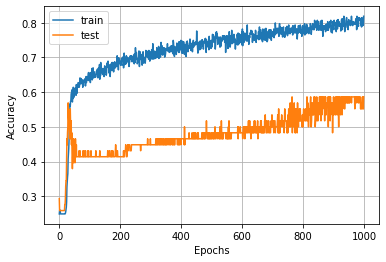

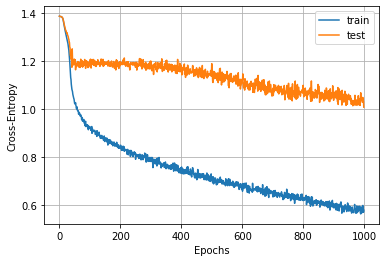


Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.58621

Epoch 00002: val_accuracy did not improve from 0.58621

Epoch 00003: val_accuracy did not improve from 0.58621

Epoch 00004: val_accuracy did not improve from 0.58621

Epoch 00005: val_accuracy did not improve from 0.58621

Epoch 00006: val_accuracy did not improve from 0.58621

Epoch 00007: val_accuracy did not improve from 0.58621

Epoch 00008: val_accuracy did not improve from 0.58621

Epoch 00009: val_accuracy did not improve from 0.58621

Epoch 00010: val_accuracy did not improve from 0.58621

Epoch 00011: val_accuracy did not improve from 0.58621

Epoch 00012: val_accuracy did not improve from 0.58621

Epoch 00013: val_accuracy did not improve from 0.58621

Epoch 00014: val_accuracy did not improve from 0.58621

Epoch 00015: val_accuracy did not improve from 0.58621

Epoch 00016: val_accuracy did not improve from 0.58621

Epoch 00017: val_accuracy did not improve from 0.58621

Epoch 00018: val_accuracy did not

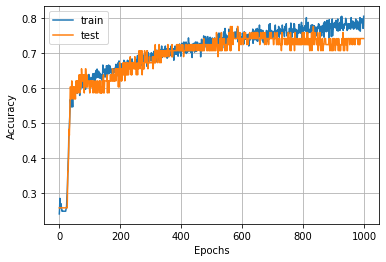

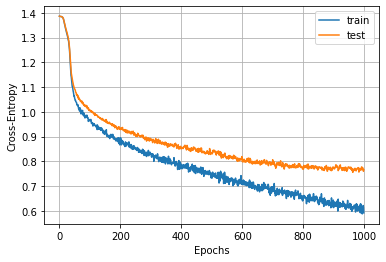


Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.77586

Epoch 00002: val_accuracy did not improve from 0.77586

Epoch 00003: val_accuracy did not improve from 0.77586

Epoch 00004: val_accuracy did not improve from 0.77586

Epoch 00005: val_accuracy did not improve from 0.77586

Epoch 00006: val_accuracy did not improve from 0.77586

Epoch 00007: val_accuracy did not improve from 0.77586

Epoch 00008: val_accuracy did not improve from 0.77586

Epoch 00009: val_accuracy did not improve from 0.77586

Epoch 00010: val_accuracy did not improve from 0.77586

Epoch 00011: val_accuracy did not improve from 0.77586

Epoch 00012: val_accuracy did not improve from 0.77586

Epoch 00013: val_accuracy did not improve from 0.77586

Epoch 00014: val_accuracy did not improve from 0.77586

Epoch 00015: val_accuracy did not improve from 0.77586

Epoch 00016: val_accuracy did not improve from 0.77586

Epoch 00017: val_accuracy did not improve from 0.77586

Epoch 00018: val_accuracy did not

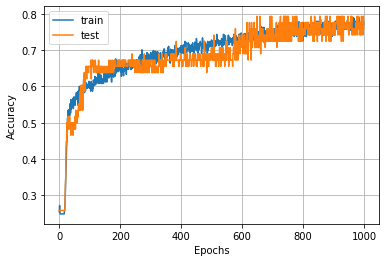

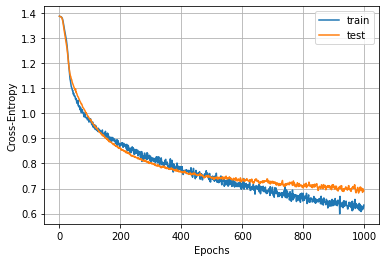


Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.79310

Epoch 00002: val_accuracy did not improve from 0.79310

Epoch 00003: val_accuracy did not improve from 0.79310

Epoch 00004: val_accuracy did not improve from 0.79310

Epoch 00005: val_accuracy did not improve from 0.79310

Epoch 00006: val_accuracy did not improve from 0.79310

Epoch 00007: val_accuracy did not improve from 0.79310

Epoch 00008: val_accuracy did not improve from 0.79310

Epoch 00009: val_accuracy did not improve from 0.79310

Epoch 00010: val_accuracy did not improve from 0.79310

Epoch 00011: val_accuracy did not improve from 0.79310

Epoch 00012: val_accuracy did not improve from 0.79310

Epoch 00013: val_accuracy did not improve from 0.79310

Epoch 00014: val_accuracy did not improve from 0.79310

Epoch 00015: val_accuracy did not improve from 0.79310

Epoch 00016: val_accuracy did not improve from 0.79310

Epoch 00017: val_accuracy did not improve from 0.79310

Epoch 00018: val_accuracy did not

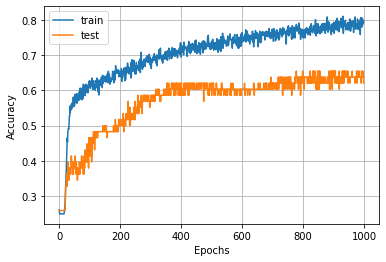

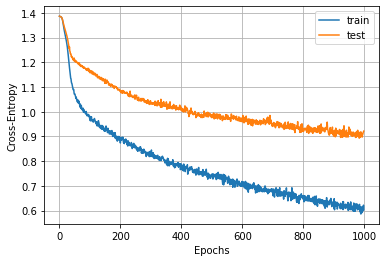


Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.79310

Epoch 00002: val_accuracy did not improve from 0.79310

Epoch 00003: val_accuracy did not improve from 0.79310

Epoch 00004: val_accuracy did not improve from 0.79310

Epoch 00005: val_accuracy did not improve from 0.79310

Epoch 00006: val_accuracy did not improve from 0.79310

Epoch 00007: val_accuracy did not improve from 0.79310

Epoch 00008: val_accuracy did not improve from 0.79310

Epoch 00009: val_accuracy did not improve from 0.79310

Epoch 00010: val_accuracy did not improve from 0.79310

Epoch 00011: val_accuracy did not improve from 0.79310

Epoch 00012: val_accuracy did not improve from 0.79310

Epoch 00013: val_accuracy did not improve from 0.79310

Epoch 00014: val_accuracy did not improve from 0.79310

Epoch 00015: val_accuracy did not improve from 0.79310

Epoch 00016: val_accuracy did not improve from 0.79310

Epoch 00017: val_accuracy did not improve from 0.79310

Epoch 00018: val_accuracy did not

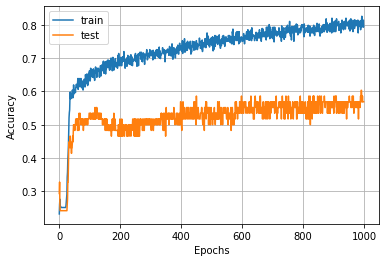

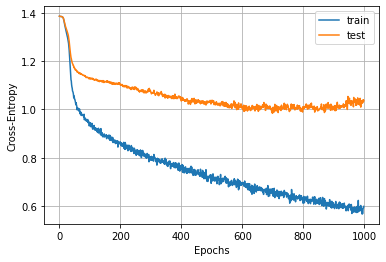


Iteration: 6

Epoch 00001: val_accuracy did not improve from 0.79310

Epoch 00002: val_accuracy did not improve from 0.79310

Epoch 00003: val_accuracy did not improve from 0.79310

Epoch 00004: val_accuracy did not improve from 0.79310

Epoch 00005: val_accuracy did not improve from 0.79310

Epoch 00006: val_accuracy did not improve from 0.79310

Epoch 00007: val_accuracy did not improve from 0.79310

Epoch 00008: val_accuracy did not improve from 0.79310

Epoch 00009: val_accuracy did not improve from 0.79310

Epoch 00010: val_accuracy did not improve from 0.79310

Epoch 00011: val_accuracy did not improve from 0.79310

Epoch 00012: val_accuracy did not improve from 0.79310

Epoch 00013: val_accuracy did not improve from 0.79310

Epoch 00014: val_accuracy did not improve from 0.79310

Epoch 00015: val_accuracy did not improve from 0.79310

Epoch 00016: val_accuracy did not improve from 0.79310

Epoch 00017: val_accuracy did not improve from 0.79310

Epoch 00018: val_accuracy did not

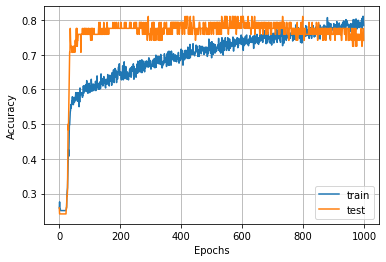

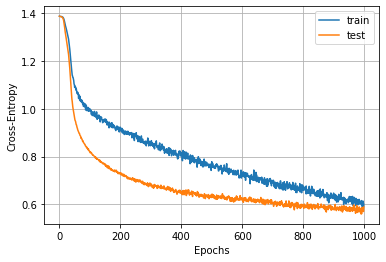


Iteration: 7

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

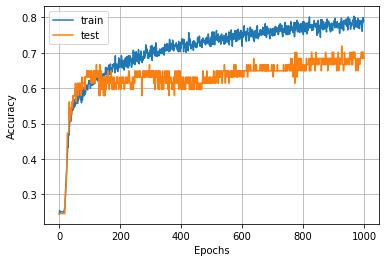

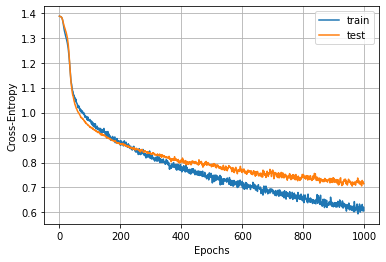


Iteration: 8

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

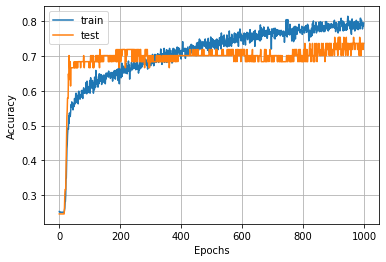

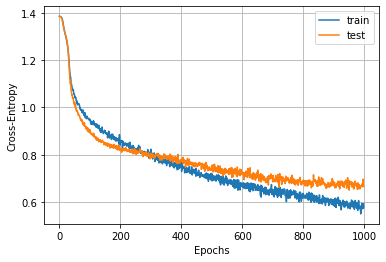


Iteration: 9

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

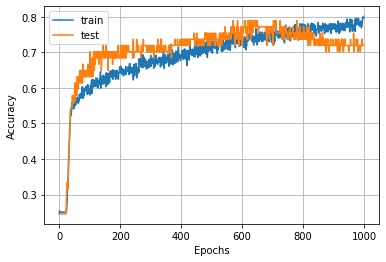

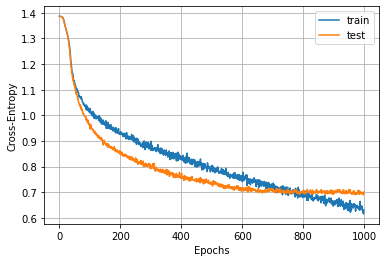


Iteration: 10

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did no

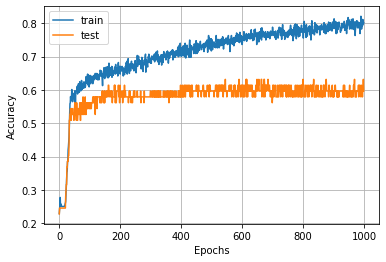

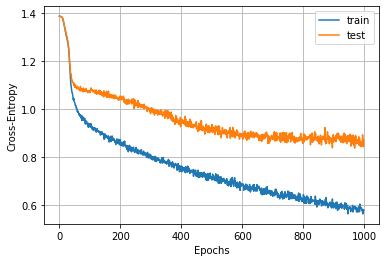


Resultados:
loss: [1.0070948210255852, 0.7667939005226925, 0.6909621419577763, 0.92142987456815, 1.0374323499613796, 0.5891120187167463, 0.7154778482621176, 0.6654353831943712, 0.7014279396910417, 0.8702933098140516]
accuracy: [0.5862069129943848, 0.7413793206214905, 0.7586206793785095, 0.6206896305084229, 0.568965494632721, 0.7413793206214905, 0.6842105388641357, 0.7368420958518982, 0.719298243522644, 0.5964912176132202]
kappa: [0.4463007159904535, 0.6544876886417792, 0.6782884310618067, 0.492442322991249, 0.42460317460317465, 0.6555819477434679, 0.5779514603044016, 0.6497337156902908, 0.625615763546798, 0.4631449631449631]
Tiempo: 2372.841388463974


In [23]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test),
                      verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
print("Tiempo:", fin - inicio)

In [24]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_55 (TimeDis (None, 1, 264, 8, 128)    1280      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 1, 132, 4, 128)    0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, 1, 132, 4, 128)    147584    
_________________________________________________________________
time_distributed_58 (TimeDis (None, 1, 66, 2, 128)     0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 1, 66, 2, 128)     147584    
_________________________________________________________________
time_distributed_60 (TimeDis (None, 1, 16896)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)               

In [25]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6754
std: (+/- 0.0707)
Mean Kappa: 0.5668
std: (+/- 0.0946)
Max Accuracy: 0.7586
Max Kappa: 0.6783


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 18 22:34:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |   4899MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  